In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.utils import plot_model
from keras.layers import *
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import InceptionV3, EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import SGD
#import gradio as gr

# **Read Data and Preprocess**

In [ ]:
def read_and_resize_images(folder_path, label, img_size):
    images = []
    internal_labels = []

    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                if img.shape[:2] == img_size:
                    images.append(img)
                    internal_labels.append(label)

    num_images = len(images)
    print(f"Loaded {num_images} images for class {label} from folder {folder_path}")
    return images, internal_labels

# **Load Data**

In [ ]:
def load_dataset(root_folder,img_size):
    all_images = []
    all_labels = []
    class_folders = sorted(os.listdir(root_folder))

    for label, class_folder in enumerate(class_folders):
        class_path = os.path.join(root_folder, class_folder)
        if os.path.isdir(class_path):
            images, labels = read_and_resize_images(class_path, label,img_size)
            all_images.extend(images)
            all_labels.extend(labels)

    # Convert labels to one-hot encoding
    all_labels = to_categorical(all_labels, num_classes=len(class_folders))

    return np.array(all_images), np.array(all_labels)

# **Plot image from each class**

In [ ]:
def plot_images(images, labels, class_folders):
    num_classes = len(class_folders)
    fig, axes = plt.subplots(1, num_classes, figsize=(15, 3))

    for i in range(num_classes):
        class_images = images[labels[:, i] == 1]
        axes[i].imshow(class_images[0][:, :, ::-1])
        axes[i].set_title(f" {class_folders[i]}")
        axes[i].axis('off')

    plt.show()


# **Data Augmentation**

In [ ]:
def augment_images(images):
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_images = []
    for img in images:
        img = img.reshape((1,) + img.shape)
        for batch in datagen.flow(img, batch_size=1):
            augmented_images.append(batch[0])
            break

    return np.array(augmented_images)

# **Creat and train model**

# Inceptionv3

In [ ]:
def create_inceptionv3_model(shape):
    InceptionV3_model = InceptionV3(input_shape=shape, weights='imagenet', include_top=False)

    for layer in InceptionV3_model.layers:
      layer.trainable = True

    # for layer in InceptionV3_model.layers[249:]:
    #     layer.trainable = True

    InceptionV3_last_output = InceptionV3_model.output
    InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
    InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
    InceptionV3_x = Dropout(0.5)(InceptionV3_x)
    InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)

    InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input, outputs=InceptionV3_x)
    InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    return InceptionV3_x_final_model

In [ ]:
def train_inceptionv3_model(model, train_generator, validation_generator, number_of_epochs=200):
    inception_filepath = 'inceptionv3_' +'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
    inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
    inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=150)

    history = model.fit(train_generator, epochs=number_of_epochs, validation_data=validation_generator,
                        callbacks=[inception_checkpoint, inception_early_stopping], verbose=1)
    test_loss, test_acc = model.evaluate(validation_generator)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])  # Change 'acc' to 'accuracy'
    plt.plot(history.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()
    return history


# VGG16 Model

In [ ]:
def create_VGG16_model(shape):
    vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=shape)

    for layer in vgg16_model.layers:
        layer.trainable = True

    last_output = vgg16_model.layers[-1].output
    vgg_x = Flatten()(last_output)
    vgg_x = Dense(100, activation='relu')(vgg_x)
    vgg_x = Dense(6, activation='softmax')(vgg_x)

    vgg16_final_model = Model(vgg16_model.input, vgg_x)
    vgg16_final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return vgg16_final_model

In [ ]:
def train_VGG16_model(model, train_generator, validation_generator, epochs, checkpoint_filepath, early_stopping_patience):
      vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
      vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=early_stopping_patience)
      history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator,callbacks=[vgg_checkpoint, vgg_early_stopping], verbose=1)
      test_loss, test_acc = model.evaluate(validation_generator)
      print(f'Test Loss: {test_loss:.4f}')
      print(f'Test Accuracy: {test_acc:.4f}')
      plt.figure(figsize=(12, 4))
      # Plot training & validation accuracy values
      plt.subplot(1, 2, 1)
      plt.plot(history.history['acc'])
      plt.plot(history.history['val_acc'])
      plt.title('Model accuracy')
      plt.xlabel('Epoch')
      plt.ylabel('Accuracy')
      plt.legend(['Train', 'Test'], loc='upper left')

      # Plot training & validation loss values
      plt.subplot(1, 2, 2)
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend(['Train', 'Test'], loc='upper left')

      plt.tight_layout()
      plt.show()
      return history

# ResNet Model

In [ ]:
def create_ResNet50_model(shape):
  ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=shape, classes=6)

  for layers in ResNet50_model.layers:
    layers.trainable=True

  opt = SGD(lr=0.01,momentum=0.7)
  resnet50_x = Flatten()(ResNet50_model.output)
  resnet50_x = Dense(256,activation='relu')(resnet50_x)
  resnet50_x = Dense(6,activation='softmax')(resnet50_x)
  resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
  resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])
  return resnet50_x_final_model

In [ ]:
def train_ResNet50_model(model, train_generator, validation_generator, epochs=200):
    resnet_filepath = 'resnet50' + '-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
    resnet_checkpoint = ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    resnet_early_stopping = EarlyStopping(monitor='loss', patience=150)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=150, min_lr=0.000002)
    callback_list = [resnet_checkpoint, resnet_early_stopping, reduce_lr]
    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=callback_list, verbose=1)
    test_loss, test_acc = model.evaluate(validation_generator)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    plt.figure(figsize=(12, 4))
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()
    return history


# EfficientNet Model

In [ ]:
def create_EfficientNet_model(shape):
    EfficientNet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=shape, classes=6)

    for layer in EfficientNet_model.layers:
        layer.trainable = True

    opt = SGD(lr=0.01, momentum=0.7)
    efficientnet_x = Flatten()(EfficientNet_model.output)
    efficientnet_x = Dense(256, activation='relu')(efficientnet_x)
    efficientnet_x = Dense(6, activation='softmax')(efficientnet_x)

    efficientnet_final_model = Model(inputs=EfficientNet_model.input, outputs=efficientnet_x)
    efficientnet_final_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

    return efficientnet_final_model

In [ ]:
def train_EfficientNet_model(model, train_generator, validation_generator, epochs=2):
    efficientnet_filepath = 'efficientnet' + '-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.h5'
    efficientnet_checkpoint = ModelCheckpoint(efficientnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    efficientnet_early_stopping = EarlyStopping(monitor='loss', patience=150)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
    callback_list = [efficientnet_checkpoint, efficientnet_early_stopping, reduce_lr]

    history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator, callbacks=callback_list, verbose=1)
    test_loss, test_acc = model.evaluate(validation_generator)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    plt.figure(figsize=(12, 4))
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.tight_layout()
    plt.show()
    return history


# **Main**

Loaded 516 images for class 0 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Ajloun Castle
Loaded 516 images for class 1 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Jeresh
Loaded 500 images for class 2 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Petra
Loaded 537 images for class 3 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Roman amphitheater
Loaded 502 images for class 4 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Umm_Qais
Loaded 504 images for class 5 from folder /content/drive/MyDrive/Jordan Archaeological Sites/Wadi_Rum


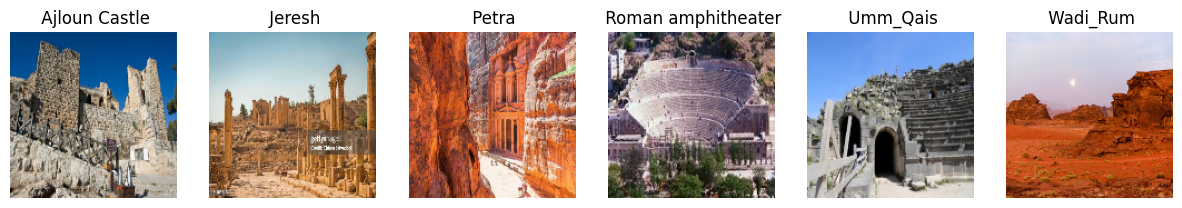

Total number of data after augmentation: 6150


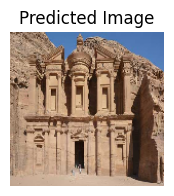

You entered: vggnet
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/200
173/173 [==============================] - ETA: 0s - loss: 1.0552 - acc: 0.7586
Epoch 1: val_acc improved from -inf to 0.83902, saving model to vgg_16_-saved-model-01-acc-0.84.hdf5
173/173 [==============================] - 23s 105ms/step - loss: 1.0552 - acc: 0.7586 - val_loss: 0.5006 - val_acc: 0.8390


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
173/173 [==============================] - ETA: 0s - loss: 0.2482 - acc: 0.9153
Epoch 2: val_acc improved from 0.83902 to 0.85366, saving model to vgg_16_-saved-model-02-acc-0.85.hdf5
173/173 [==============================] - 13s 75ms/step - loss: 0.2482 - acc: 0.9153 - val_loss: 0.4439 - val_acc: 0.8537
Epoch 3/200
173/173 [==============================] - ETA: 0s - loss: 0.1302 - acc: 0.9537
Epoch 3: val_acc improved from 0.85366 to 0.88293, saving model to vgg_16_-saved-model-03-acc-0.88.hdf5
173/173 [==============================] - 13s 75ms/step - loss: 0.1302 - acc: 0.9537 - val_loss: 0.3675 - val_acc: 0.8829
Epoch 4/200
173/173 [==============================] - ETA: 0s - loss: 0.0689 - acc: 0.9781
Epoch 4: val_acc improved from 0.88293 to 0.89593, saving model to vgg_16_-saved-model-04-acc-0.90.hdf5
173/173 [==============================] - 14s 77ms/step - loss: 0.0689 - acc: 0.9781 - val_loss: 0.3367 - val_acc: 0.8959
Epoch 5/200
173/173 [======================

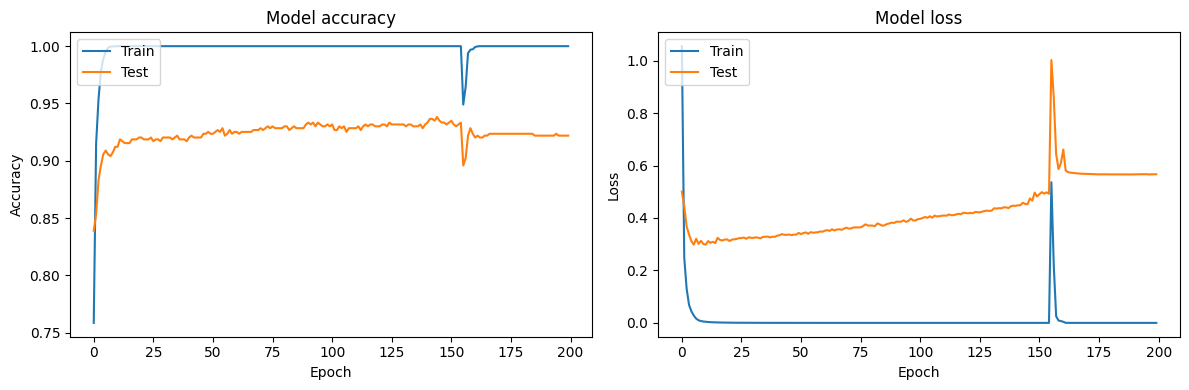

1/1 [==============================] - 0s 156ms/step
Ajloun Castle: 0.0083
Jeresh: 0.0225
Petra: 0.0476
Roman amphitheater: 0.0504
Umm_Qais: 0.7508
Wadi_Rum: 0.1204


In [ ]:
def main():
    img_size = (150, 150)
    SEED = 42
    BATCH_SIZE = 32
    BUFFER_SIZE = 1024
    shape=(150, 150, 3)
    root_folder = "/content/drive/MyDrive/Jordan Archaeological Sites"
    class_folders = sorted(os.listdir(root_folder))
    images, labels = load_dataset(root_folder,img_size)
    plot_images(images, labels, class_folders)

    augmented_images = augment_images(images)
    images = np.concatenate((images, augmented_images), axis=0)
    labels = np.concatenate((labels, labels), axis=0)
    print("Total number of data after augmentation:", len(images))



    indices = np.arange(len(images))
    np.random.seed(SEED)
    np.random.shuffle(indices)

    train_size = int(0.9 * len(indices))
    val_size = int(0.1 * len(indices))

    train_indices = indices[:train_size]
    val_indices = indices[train_size:(train_size + val_size)]

    train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(images[train_indices]), tf.convert_to_tensor(labels[train_indices])))
    val_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(images[val_indices]), tf.convert_to_tensor(labels[val_indices])))

    train_dataset = train_dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

    image_path = "/content/drive/MyDrive/Test Images/الدير.jpg"
    img = cv2.imread(image_path)
    img = cv2.resize(img, (150, 150))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    plt.figure(figsize=(2, 2))
    plt.imshow(img[0][:, :, ::-1])
    plt.title("Predicted Image")
    plt.axis('off')
    plt.show()

    user_input = input("Pleas Select which model you need :\n 1-InceptionV3\n2-Efficientnet\n3-ResNet\n4-VGGNet\n ")
    print("You entered:", user_input)
    if(user_input.lower()=='inceptionv3'):
          inception_model = create_inceptionv3_model(shape)
          history = train_inceptionv3_model(inception_model, train_dataset, val_dataset)
          predictions = inception_model.predict(img)

          # Display predicted probabilities for each class
          for i, class_name in enumerate(class_folders):
            class_probability = predictions[0, i]
            print(f"{class_name}: {class_probability:.4f}")
    elif(user_input.lower()=='vggnet'):
         vgg16_filepath = 'vgg_16_' + '-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
         vgg_16_model = create_VGG16_model(shape)
         # Assuming you have train_generator and validation_generator defined somewhere
         # train_vgg16_model function handles the training and checkpoints
         vgg16_history = train_VGG16_model(model=vgg_16_model,train_generator=train_dataset,validation_generator=val_dataset,
                                           epochs=200,checkpoint_filepath=vgg16_filepath,early_stopping_patience=150)
         predictions = vgg_16_model.predict(img)
         # Display predicted probabilities for each class
         for i, class_name in enumerate(class_folders):
            class_probability = predictions[0, i]
            print(f"{class_name}: {class_probability:.4f}")
    elif(user_input.lower()=='resnet'):
         resnet50_model = create_ResNet50_model(shape)
         history = train_ResNet50_model(resnet50_model, train_dataset, val_dataset)
         predictions = resnet50_model.predict(img)
         # Display predicted probabilities for each class
         for i, class_name in enumerate(class_folders):
            class_probability = predictions[0, i]
            print(f"{class_name}: {class_probability:.4f}")
    elif user_input.lower() == 'efficientnet':
          efficientnet_model = create_EfficientNet_model(shape)
          efficientnet_history = train_EfficientNet_model(efficientnet_model, train_dataset, val_dataset)

          # plot_history(efficientnet_history)


          # Assuming 'img' is an example image you want to make predictions on
          predictions = efficientnet_model.predict(img)
          # Display predicted probabilities for each class
          for i, class_name in enumerate(class_folders):
            class_probability = predictions[0, i]
            print(f"{class_name}: {class_probability:.4f}")

if __name__ == "__main__":
    main()


# **Prediction Using saved Model**

1/1 [==============================] - 0s 195ms/step
Ajloun Castle: 0.0000
Jeresh: 0.0000
Petra: 0.0000
Roman amphitheater: 0.0000
Umm_Qais: 1.0000
Wadi_Rum: 0.0000


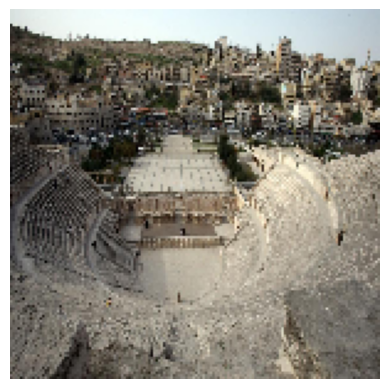

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load the trained model
model = load_model('/content/vgg_16_-saved-model-90-acc-0.93.hdf5')

# Load and preprocess the image
img_path = '/content/WhatsApp Image 2024-01-26 at 22.31.51.jpeg'
img = image.load_img(img_path, target_size=(150, 150))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

# Make predictions
predictions = model.predict(img_array)

# Define class names (replace this with your actual class names)
class_names = ["Ajloun Castle", "Jeresh", "Petra", "Roman amphitheater", "Umm_Qais", "Wadi_Rum"]

# Print class names and probabilities
for class_index, (class_name, probability) in enumerate(zip(class_names, predictions[0])):
    print(f"{class_name}: {probability:.4f}")

# Plot the image
plt.imshow(img)
plt.axis('off')
plt.show()


# **Gradio Interface**

In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.models import load_model

# Load  saved  models
efficientnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Saved Model/efficientnet-saved-model-06-val_acc-0.98.hdf5')
resnet_model = tf.keras.models.load_model('/content/drive/MyDrive/Saved Model/resnet50-saved-model-79-val_acc-1.00.hdf5')
VGGNet_model = tf.keras.models.load_model('/content/drive/MyDrive/Saved Model/vgg_16_-saved-model-89-acc-0.93.hdf5')
InceptionV3_model = tf.keras.models.load_model('/content/drive/MyDrive/Saved Model/inceptionv3_-saved-model-59-val_accuracy-0.94.hdf5')



# Define class names corresponding to your dataset
class_names = ["Ajloun Castle", "Jeresh", "Petra", "Roman amphitheater", "Umm_Qais", "Wadi_Rum"]  # Replace with your actual class names

# Define the classify_image function
def classify_image(img, model_choice):
    # Resize the input image based on the selected model's expected input shape
    if model_choice == "ResNet":
        img = tf.image.resize(img, (150, 150))  # ResNet50 input size
        img = image.img_to_array(img)
        img = img.copy()  # Make a copy of the image array
        img = resnet_preprocess_input(img)
    elif model_choice == "EfficientNet":
        img = tf.image.resize(img, (150, 150))
        img = image.img_to_array(img)
        img = preprocess_input(img)
    elif model_choice == "VGGNet":
        img = tf.image.resize(img, (150, 150))
        img = image.img_to_array(img)
        img = preprocess_input(img)
    elif model_choice == "InceptionV3":
        img = tf.image.resize(img, (150, 150))
        img = image.img_to_array(img)
        img = preprocess_input(img)
    else:
        return "Invalid model choice"

    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Make predictions based on the selected model
    if model_choice == "ResNet":
        predictions = resnet_model.predict(img)
    elif model_choice == "EfficientNet":
        predictions = efficientnet_model.predict(img)
    elif model_choice == "VGGNet":
        predictions = VGGNet_model.predict(img)
    elif model_choice == "InceptionV3":
        predictions = InceptionV3_model.predict(img)

    class_idx = tf.argmax(predictions[0])

    # Map class index to class name
    class_name = class_names[class_idx]

    # Return the predicted class name as a string
    return f"Predicted class using {model_choice}: {class_name}"

# Create a Gradio interface with a dropdown for model selection
iface = gr.Interface(
    fn=classify_image,
    inputs=["image", gr.Dropdown(["ResNet", "EfficientNet","VGGNet","InceptionV3"], label="Select Model")],
    outputs="text",
    live=True
)

# Launch the Gradio interface
iface.launch(debug=True,share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://9401330e87f3b71f2b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
